## Dimensionality Reduction##

Fitting and overfitting get worse with ''curse of dimensionality'' Bellman 1961

Think about a hypersphere. Its volume is  given by

\begin{equation}
  V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)},
\end{equation}

where $\Gamma(z)$ is the complete gamma function, $D$ is the dimension, and $r$ the radius of the sphere.

<!-- TEASER_END -->

If you populated a hypercube of size $2r$ how much data would be enclosed by the hypersphere
- as $D$ increases the fractional volume enclosed by the hypersphere goes to 0! 

For example: the SDSS comprises a sample of 357 million sources. 
- each source has 448 measured attributes
- selecting just 30 (e.g., magnitude, size..) and normalizing the data range $-1$ to $1$

probability of having one of the 357 million sources reside within a unit hypersphere 1 in 1.4$\times 10^5$.

/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


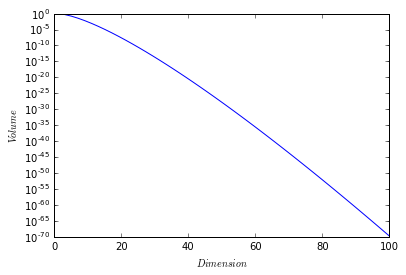

In [1]:
%matplotlib inline
import numpy as np
import scipy.special as sp
from matplotlib import pyplot as plt

def unitVolume(dimension, radius=1.):
    return 2*(radius**dimension *np.pi**(dimension/2.))/(dimension*sp.gamma(dimension/2.))

dim = np.linspace(1,100)

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dim,unitVolume(dim)/2.**dim)

ax.set_yscale('log')
ax.set_xlabel('$Dimension$')
ax.set_ylabel('$Volume$')

plt.show()


In [14]:
D=30;unitVolume(D)/(2.**D)

2.0410263396641429e-14

## Increasing interest in dimensionality reduction
<img width="500" src="figures/pca.png">

## What can we do to reduce the dimensions##

**Principal component analysis or the Karhunen-Loeve transform**

The first refuge of a scoundrel...

<img width="500" src="files/figures/pca-scatter.png">

Points are  correlated along a particular direction which doesn't align with the initial choice of axes. 
- we should rotate our axes to align with this correlation. 
- rotation preserves the relative ordering of data

Choose  rotation to maximize the ability to discriminate between the data points
*   first axis, or <u>principal component</u>, is direction of maximal variance
*   second principal component is orthogonal to the first component and maximizes the residual variance
*   ...

## Derivation of principal component analyses##

Set of data $X$: $N$ observations by $K$ measurements

Center data by subtracting the mean **Why?**

The covariance is

>$ 
C_X=\frac{1}{N-1}X^TX,
$

$N-1$ as the sample covariance matrix 

We want a projection, $R$,  aligned with the directions of maximal variance ($Y= X R$) with covariance 

>$
C_{Y} = R^T X^T X R = R^T C_X R
$

Derive  principal component by maximizing its variance (using Lagrange multipliers and constraint)

> $
\phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1).
$

derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ set to 0

> $
C_Xr_1 - \lambda_1 r_1 = 0.
$

$\lambda_1$ is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ and the largest eigenvalue

>$
\lambda_1 =  r_1^T C_X r_1
$

Other  principal components  derived by
applying additional constraint that components are uncorrelated (e.g., $r^T_2 C_X r_1 = 0$).

## Lagrangian mulitpliers
<img width="500" src="figures/1000px-LagrangeMultipliers2D.png">

## Computation of principal components##

Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

** SVD given by**

>$
U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X,
$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

> $
\begin{eqnarray}
  C_X &=& \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      &=& V \Sigma U^T U \Sigma V^T\nonumber\\
      &=& V \Sigma^2 V^T.
\end{eqnarray}
$

right singular vectors $V$ are the principal components. We can calculate principal components from the SVD of $X$ - we dont need $C_X$.

<img width="500" src="figures/fig_svd_visual_1.png">
Singular value decomposition (SVD) can factorize an N x K matrix into $U \Sigma V^T$. There are different conventions for computing the SVD in the literature, and this figure illustrates the convention used in this text. The matrix of singular values $\Sigma$ is always a square matrix of size [R x R] where R = min(N, K). The shape of the resulting U and V matrices depends on whether N or K is larger. The columns of the matrix U are called the left-singular vectors, and the columns of the matrix V are called the right-singular vectors. The columns are orthonormal bases, and satisfy $U^T U = V^T V = I$.

## Preparing data for PCA##

- Center data by subtracting the mean of each dimension
- For heterogeneous data (e.g., galaxy shape and flux) divide by  variance (whitening). **why?**
- For spectra or images normalize each row so integrated flux of each object is one.  

/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


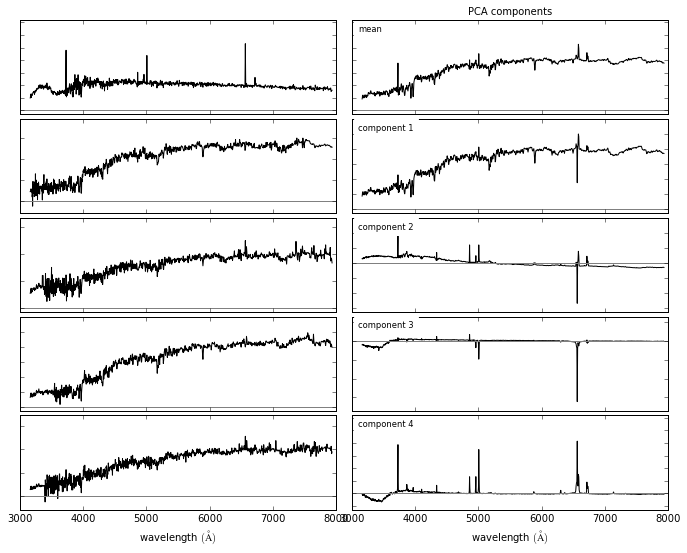

In [15]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)


#----------------------------------------------------------------------
# Compute PCA
def compute_PCA(n_components=5):
#    np.random.seed(500)
    nrows = 500
    ind = np.random.randint(spectra.shape[0], size=nrows)
    
    spec_mean = spectra[ind].mean(0)
#    spec_mean = spectra[:50].mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1)
    pca.fit(spectra[ind])
    pca_comp = np.vstack([spec_mean,
                          pca.components_])
    evals = pca.explained_variance_ratio_

    return pca_comp, evals

n_components = 5
decompositions, evals = compute_PCA(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(n_components):
    ax = fig.add_subplot(n_components, 2, 2*j+2)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wavelengths, decompositions[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')


    

plt.show()

## Interpreting the PCA##

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

>$ \begin{equation}
  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),
\end{equation}
$

Truncating this expansion (i.e., $r<R$)

>$\begin{equation}
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
\end{equation}
$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


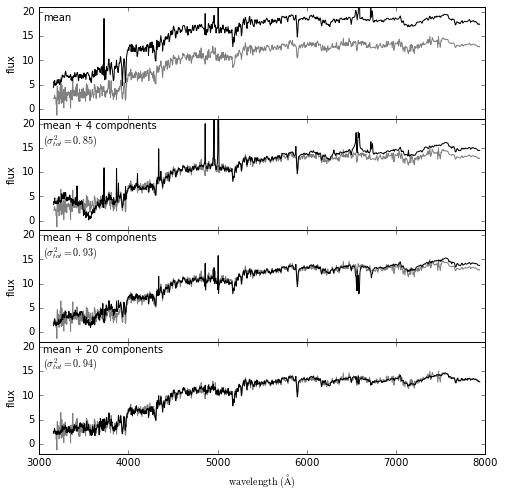

In [5]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

## Comparing dimensionality reduction (PCA vs LLE)
<img width="500" src="figures/fig_PCA_LLE_1.png"> <img width="500" src="figures/fig_PCA_LLE_2.png">




*  Comparisons between the eigenvectors derived from PCA and known spectral types of galaxies
have shown that these statistically orthogonal components correlate
strongly with specific physical properties 
*  given the cumulative nature of the sum of
variances used in PCA, astrophysically interesting components within
the spectra (e.g., sharp spectral lines or transient features for
certain galaxy populations) may not be reflected in the largest PCA
components. 
- sum of
linear components can efficiently reconstruct the features within the
data does not always hold.  An example of this is the variation in
broad emission lines (such as those from quasars). The
variation in line width is an inherently nonlinear process and can
require a large number of components to fully characterize:
for broad line quasars over 30
components are required to reproduce the underlying spectra compared
to the 10 required for quiescent and star-forming galaxies.  

## PCA with missing data##

Observed spectrum, $x^o$ is the true spectrum, ${x}$ plus a wavelength-dependent weight, ${w}$.  

Weight is zero where data are missing and $1/{\sigma}^2$ for rest

Minimizing the quadratic deviation between  ${x}^o$ truncated reconstruction, $\sum_i \theta_i {e}_i$
and solving for $\theta_i$ gives

>$\begin{equation}
	\sum_k \theta_i {w}(k) {e}_i(k) {e}_j(k) =
	\sum_k {w}(k) {x}^o(k) {e}_j(k),
\end{equation}
$

If $M_{ij} = \sum_k {w}(k) {e}_i(k) {e}_j(k)$ and $F_i = \sum_k {w}(k) {x}^o(k) {e}_i(k)$ then 

>$\begin{equation}
	\theta_i = \sum_j M_{ij}^{-1} F_{j},
\end{equation}
$

- $F_j$ are  coefficients derived from  gappy data
- $M_{ij}^{-1}$ shows how correlated  eigenvectors are over the missing regions.

An estimate of the uncertainty on the
reconstruction coefficients is given by

>$\begin{equation}
%Cov(\theta_i,\theta_j) = \frac{1}{N}M_{ij}^{-1}
{\rm Cov}(\theta_i,\theta_j) = M_{ij}^{-1}.
\end{equation}
$

Accuracy of this reconstruction will depend on the distribution of
the gaps within the data vector.

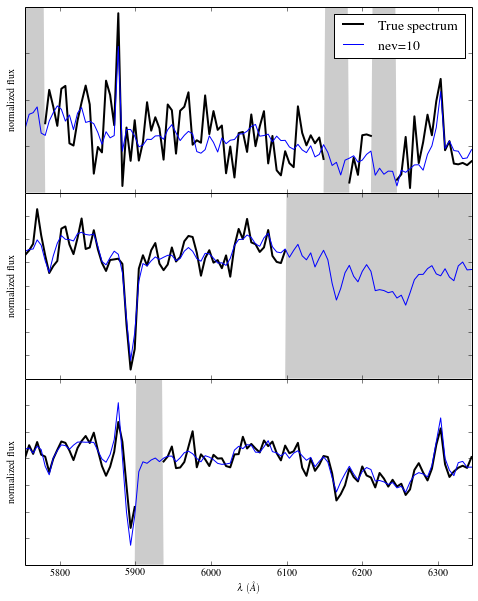

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets import sdss_corrected_spectra

#------------------------------------------------------------
# Get spectra and eigenvectors used to reconstruct them
data = fetch_sdss_corrected_spectra()
spec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)
evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((lam > 5750) & (lam < 6350))
lam = lam[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spec_i_centered = spec[i] / norms[i] - mu
    coeffs = np.dot(spec_i_centered, evecs.T)

    # blank out masked regions
    spec_i = spec[i]
    mask_i = mask[i]
    spec_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(lam, spec_i[i_plot], '-', color='k', lw=2,
            label='True spectrum')

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'nev=%i' % nev
        spec_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(lam, spec_i_recons[i_plot], label=label)

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([lam[:1], lam, lam[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(lam[0], lam[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1, prop=dict(size=14))

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()